In [1]:
import pandas as pd
import numpy as np

from river_dl.postproc_utils import fmt_preds_obs
from river_dl.loss_functions import rmse, nse, kge

import datetime

2021-11-03 12:05:06.848301: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/slurm/18.08.8/lib64/slurm:/cm/shared/apps/slurm/18.08.8/lib64:/cm/local/apps/gcc/8.2.0/lib:/cm/local/apps/gcc/8.2.0/lib64:/.singularity.d/libs
2021-11-03 12:05:06.848336: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def filter_negative_preds(y_true, y_pred):
    """
    filters out negative predictions and prints a warning if there are >5% of predictions as negative
    :param y_true: [array-like] observed y_dataset values
    :param y_pred: [array-like] predicted y_dataset values
    :return: [array-like] filtered data
    """
    # print a warning if there are a lot of negatives
    n_negative = len(y_pred[y_pred < 0])
    perc_negative = n_negative / len(y_pred)
    if perc_negative > 0.05:
        print(
            f"Warning than 5% of predictions were negative {n_negative} of\
                {len(y_pred)}"
        )
    # filter out negative predictions
    y_true = np.where(y_pred < 0, np.nan, y_true)
    y_pred = np.where(y_pred < 0, np.nan, y_pred)
    return y_true, y_pred

def rmse_logged(y_true, y_pred):
    """
    compute the rmse of the logged data
    :param y_true: [array-like] observed y_dataset values
    :param y_pred: [array-like] predicted y_dataset values
    :return: [float] the rmse of the logged data
    """
    y_true, y_pred = filter_negative_preds(y_true, y_pred)
    return rmse(np.log(y_true), np.log(y_pred))


def nse_logged(y_true, y_pred):
    """
    compute the rmse of the logged data
    :param y_true: [array-like] observed y_dataset values
    :param y_pred: [array-like] predicted y_dataset values
    :return: [float] the nse of the logged data
    """
    y_true, y_pred = filter_negative_preds(y_true, y_pred)
    return nse(np.log(y_true), np.log(y_pred))

def filter_by_percentile(y_true, y_pred, percentile, less_than=True):
    """
    filter an array by a percentile of the observations. The data less than
    or greater than if `less_than=False`) will be changed to NaN
    :param y_true: [array-like] observed y_dataset values
    :param y_pred: [array-like] predicted y_dataset values
    :param percentile: [number] percentile number 0-100
    :param less_than: [bool] whether you want the data *less than* the
    percentile. If False, the data greater than the percentile will remain.
    :return: [array-like] filtered data
    """
    percentile_val = np.nanpercentile(y_true, percentile)
    if less_than:
        y_true_filt = np.where(y_true < percentile_val, y_true, np.nan)
        y_pred_filt = np.where(y_true < percentile_val, y_pred, np.nan)
    else:
        y_true_filt = np.where(y_true > percentile_val, y_true, np.nan)
        y_pred_filt = np.where(y_true > percentile_val, y_pred, np.nan)
    return y_true_filt, y_pred_filt


def percentile_metric(y_true, y_pred, metric, percentile, less_than=True):
    """
    compute an evaluation metric for a specified percentile of the observations
    :param y_true: [array-like] observed y_dataset values
    :param y_pred: [array-like] predicted y_dataset values
    :param metric: [function] metric function
    :param percentile: [number] percentile number 0-100
    :param less_than: [bool] whether you want the data *less than* the
    percentile. If False, the data greater than the percentile will remain.
    """
    y_true_filt, y_pred_filt = filter_by_percentile(
        y_true, y_pred, percentile, less_than
    )
    return metric(y_true_filt, y_pred_filt)

def calc_metrics(df):
    """
    calculate metrics (e.g., rmse and nse)
    :param df:[pd dataframe] dataframe of observations and predictions for
    one reach. dataframe must have columns "obs" and "pred"
    :return: [pd Series] various evaluation metrics (e.g., rmse and nse)
    """
    obs = df["obs"].values
    pred = df["pred"].values
    if len(obs) > 10:
        metrics = {
            "rmse": rmse(obs, pred).numpy(),
            "nse": nse(obs, pred).numpy(),
            "rmse_top10": percentile_metric(
                obs, pred, rmse, 90, less_than=False
            ).numpy(),
            "rmse_bot10": percentile_metric(
                obs, pred, rmse, 10, less_than=True
            ).numpy(),
            "rmse_logged": rmse_logged(obs, pred).numpy(),
            "nse_top10": percentile_metric(
                obs, pred, nse, 90, less_than=False
            ).numpy(),
            "nse_bot10": percentile_metric(
                obs, pred, nse, 10, less_than=True
            ).numpy(),
            "nse_logged": nse_logged(obs, pred).numpy(),
            "kge": kge(obs, pred).numpy(),
            "rmse_logged": rmse_logged(obs, pred),
            "nse_top10": percentile_metric(obs, pred, nse, 90, less_than=False),
            "nse_bot10": percentile_metric(obs, pred, nse, 10, less_than=True),
            "nse_logged": nse_logged(obs, pred),
        }

    else:
        metrics = {
            "rmse": np.nan,
            "nse": np.nan,
            "rmse_top10": np.nan,
            "rmse_bot10": np.nan,
            "rmse_logged": np.nan,
            "nse_top10": np.nan,
            "nse_bot10": np.nan,
            "nse_logged": np.nan,
            "kge": np.nan,
        }
    return pd.Series(metrics)

def partition_metrics(
        pred_file,
        obs_file,
        partition,
        spatial_idx_name="seg_id_nat",
        time_idx_name="date",
        group=None,
        outfile=None
):
    """
    calculate metrics for a certain group (or no group at all) for a given
    partition and variable
    :param pred_file: [str] path to predictions feather file
    :param obs_file: [str] path to observations zarr file
    :param partition: [str] data partition for which metrics are calculated
    :param spatial_idx_name: [str] name of column that is used for spatial
        index (e.g., 'seg_id_nat')
    :param time_idx_name: [str] name of column that is used for temporal index
        (usually 'time')
    :param group: [str or list] which group the metrics should be computed for.
    Currently only supports 'seg_id_nat' (segment-wise metrics), 'month'
    (month-wise metrics), ['seg_id_nat', 'month'] (metrics broken out by segment
    and month), and None (everything is left together)
    :param outfile: [str] file where the metrics should be written
    :return: [pd dataframe] the condensed metrics
    """
    var_data = fmt_preds_obs(pred_file, obs_file, spatial_idx_name,
                             time_idx_name)
    var_metrics_list = []

    for data_var, data in var_data.items():
        data.reset_index(inplace=True)
        if not group:
            metrics = calc_metrics(data)
            # need to convert to dataframe and transpose so it looks like the
            # others
            metrics = pd.DataFrame(metrics).T
        elif group == "seg_id_nat":
            metrics = data.groupby(spatial_idx_name).apply(calc_metrics).reset_index()
        elif group == "month":
            metrics = (
            data.groupby(
            data[time_idx_name].dt.month)
            .apply(calc_metrics)
            .reset_index()
            )
        elif group == ["seg_id_nat", "month"]:
            metrics = (
            data.groupby(
            [data[time_idx_name].dt.month,
            spatial_idx_name])
            .apply(calc_metrics)
            .reset_index()
            )
        else:
            raise ValueError("group value not valid")

        metrics["variable"] = data_var
        metrics["partition"] = partition
        var_metrics_list.append(metrics)
        var_metrics = pd.concat(var_metrics_list)
    if outfile:
        var_metrics.to_csv(outfile, header=True, index=False)
    return var_metrics


In [3]:
exp_dir_ls = ['pretrain_1', 'pretrain_2', 'pretrain_3', 'pretrain_4', 'pretrain_5',
              'no_pretrain_1', 'no_pretrain_2', 'no_pretrain_3', 'no_pretrain_4', 'no_pretrain_5',
              'no_pretrain_1_300']

for exp_dir in exp_dir_ls:
    
    pred_file = "../river-dl/" + exp_dir + "/val_preds.feather"
    obs_file = "../river-dl/data_DRB/Obs_temp_flow_drb_full_no3558"
    spatial_idx_name= "seg_id_nat"
    time_idx_name= "date"
    
    out_file = "../river-dl/" + exp_dir + "/seasonal_month_metrics.csv"
    
    var_data = fmt_preds_obs(pred_file, obs_file, spatial_idx_name, time_idx_name)
    
    for data_var, data in var_data.items():
        
        data.reset_index(inplace=True)
        
        # get month and day
        data['month'] = data[time_idx_name].dt.month
        data['day'] = data[time_idx_name].dt.day
        
        # specify as datetime
        month_day = []
        for i in range(len(data)):
            month_day_i = datetime.datetime.strptime('2016-' + str(data['month'][i]) + '-' + str(data['day'][i]),
                                                     '%Y-%m-%d')
            month_day.append(month_day_i)
        data['date2'] = month_day
        
        # discretize into seasonal-like months
        data['seasonal_month'] = pd.cut(data['date2'],
                                        bins = [datetime.datetime(2016, 1, 1, 0, 0),
                                                datetime.datetime(2016, 1, 21, 0, 0),
                                                datetime.datetime(2016, 2, 21, 0, 0),
                                                datetime.datetime(2016, 3, 21, 0, 0),
                                                datetime.datetime(2016, 4, 21, 0, 0),
                                                datetime.datetime(2016, 5, 21, 0, 0),
                                                datetime.datetime(2016, 6, 21, 0, 0),
                                                datetime.datetime(2016, 7, 21, 0, 0),
                                                datetime.datetime(2016, 8, 21, 0, 0),
                                                datetime.datetime(2016, 9, 21, 0, 0),
                                                datetime.datetime(2016, 10, 21, 0, 0),
                                                datetime.datetime(2016, 11, 21, 0, 0),
                                                datetime.datetime(2016, 12, 21, 0, 0),
                                                datetime.datetime(2016, 12, 31, 0, 0)],
                                        labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 0],
                                        ordered = False)
        
        metrics = (
            data.groupby(
                data['seasonal_month'])
            .apply(calc_metrics)
            .reset_index()
        )
        
        metrics.to_csv(out_file)

/opt/venv/reticulate/lib/python3.8/site-packages/river_dl/postproc_utils.py:58: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  obs = xr.open_zarr(obs_file).to_dataframe()
2021-11-03 12:06:05.177327: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: UNKNOWN ERROR (-1)
2021-11-03 12:06:05.177382: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ml-0001): /proc/driver/nvidia/version does not exist
2021-11-03 12:06:05.177970:

Warning than 5% of predictions were negative 46900 of                131950
Warning than 5% of predictions were negative 46900 of                131950
Warning than 5% of predictions were negative 46900 of                131950
Warning than 5% of predictions were negative 46900 of                131950
Warning than 5% of predictions were negative 55525 of                141050
Warning than 5% of predictions were negative 55525 of                141050
Warning than 5% of predictions were negative 55525 of                141050
Warning than 5% of predictions were negative 55525 of                141050


/tmp/ipykernel_419410/1618611449.py:29: RuntimeWarning: divide by zero encountered in log
  return rmse(np.log(y_true), np.log(y_pred))
/tmp/ipykernel_419410/1618611449.py:40: RuntimeWarning: divide by zero encountered in log
  return nse(np.log(y_true), np.log(y_pred))
/tmp/ipykernel_419410/1618611449.py:29: RuntimeWarning: invalid value encountered in log
  return rmse(np.log(y_true), np.log(y_pred))
/tmp/ipykernel_419410/1618611449.py:40: RuntimeWarning: invalid value encountered in log
  return nse(np.log(y_true), np.log(y_pred))


Warning than 5% of predictions were negative 17365 of                128765
Warning than 5% of predictions were negative 17365 of                128765
Warning than 5% of predictions were negative 17365 of                128765
Warning than 5% of predictions were negative 17365 of                128765
Warning than 5% of predictions were negative 10951 of                122850
Warning than 5% of predictions were negative 10951 of                122850
Warning than 5% of predictions were negative 10951 of                122850
Warning than 5% of predictions were negative 10951 of                122850


/opt/venv/reticulate/lib/python3.8/site-packages/river_dl/postproc_utils.py:58: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  obs = xr.open_zarr(obs_file).to_dataframe()


Warning than 5% of predictions were negative 42802 of                131950
Warning than 5% of predictions were negative 42802 of                131950
Warning than 5% of predictions were negative 42802 of                131950
Warning than 5% of predictions were negative 42802 of                131950
Warning than 5% of predictions were negative 49396 of                141050
Warning than 5% of predictions were negative 49396 of                141050
Warning than 5% of predictions were negative 49396 of                141050
Warning than 5% of predictions were negative 49396 of                141050


/tmp/ipykernel_419410/1618611449.py:29: RuntimeWarning: divide by zero encountered in log
  return rmse(np.log(y_true), np.log(y_pred))
/tmp/ipykernel_419410/1618611449.py:29: RuntimeWarning: invalid value encountered in log
  return rmse(np.log(y_true), np.log(y_pred))
/tmp/ipykernel_419410/1618611449.py:40: RuntimeWarning: divide by zero encountered in log
  return nse(np.log(y_true), np.log(y_pred))
/tmp/ipykernel_419410/1618611449.py:40: RuntimeWarning: invalid value encountered in log
  return nse(np.log(y_true), np.log(y_pred))


Warning than 5% of predictions were negative 14711 of                128765
Warning than 5% of predictions were negative 14711 of                128765
Warning than 5% of predictions were negative 14711 of                128765
Warning than 5% of predictions were negative 14711 of                128765
Warning than 5% of predictions were negative 9685 of                122850
Warning than 5% of predictions were negative 9685 of                122850
Warning than 5% of predictions were negative 9685 of                122850
Warning than 5% of predictions were negative 9685 of                122850


/opt/venv/reticulate/lib/python3.8/site-packages/river_dl/postproc_utils.py:58: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  obs = xr.open_zarr(obs_file).to_dataframe()


Warning than 5% of predictions were negative 58555 of                131950
Warning than 5% of predictions were negative 58555 of                131950
Warning than 5% of predictions were negative 58555 of                131950
Warning than 5% of predictions were negative 58555 of                131950
Warning than 5% of predictions were negative 70223 of                141050
Warning than 5% of predictions were negative 70223 of                141050
Warning than 5% of predictions were negative 70223 of                141050
Warning than 5% of predictions were negative 70223 of                141050
Warning than 5% of predictions were negative 24765 of                128765
Warning than 5% of predictions were negative 24765 of                128765
Warning than 5% of predictions were negative 24765 of                128765


/tmp/ipykernel_419410/1618611449.py:29: RuntimeWarning: divide by zero encountered in log
  return rmse(np.log(y_true), np.log(y_pred))
/tmp/ipykernel_419410/1618611449.py:40: RuntimeWarning: divide by zero encountered in log
  return nse(np.log(y_true), np.log(y_pred))
/tmp/ipykernel_419410/1618611449.py:29: RuntimeWarning: invalid value encountered in log
  return rmse(np.log(y_true), np.log(y_pred))
/tmp/ipykernel_419410/1618611449.py:40: RuntimeWarning: invalid value encountered in log
  return nse(np.log(y_true), np.log(y_pred))


Warning than 5% of predictions were negative 24765 of                128765
Warning than 5% of predictions were negative 16765 of                122850
Warning than 5% of predictions were negative 16765 of                122850
Warning than 5% of predictions were negative 16765 of                122850
Warning than 5% of predictions were negative 16765 of                122850


/opt/venv/reticulate/lib/python3.8/site-packages/river_dl/postproc_utils.py:58: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  obs = xr.open_zarr(obs_file).to_dataframe()


Warning than 5% of predictions were negative 44329 of                131950
Warning than 5% of predictions were negative 44329 of                131950
Warning than 5% of predictions were negative 44329 of                131950
Warning than 5% of predictions were negative 44329 of                131950
Warning than 5% of predictions were negative 51314 of                141050
Warning than 5% of predictions were negative 51314 of                141050
Warning than 5% of predictions were negative 51314 of                141050
Warning than 5% of predictions were negative 51314 of                141050
Warning than 5% of predictions were negative 14395 of                128765
Warning than 5% of predictions were negative 14395 of                128765
Warning than 5% of predictions were negative 14395 of                128765


/tmp/ipykernel_419410/1618611449.py:29: RuntimeWarning: divide by zero encountered in log
  return rmse(np.log(y_true), np.log(y_pred))
/tmp/ipykernel_419410/1618611449.py:29: RuntimeWarning: invalid value encountered in log
  return rmse(np.log(y_true), np.log(y_pred))
/tmp/ipykernel_419410/1618611449.py:40: RuntimeWarning: divide by zero encountered in log
  return nse(np.log(y_true), np.log(y_pred))
/tmp/ipykernel_419410/1618611449.py:40: RuntimeWarning: invalid value encountered in log
  return nse(np.log(y_true), np.log(y_pred))


Warning than 5% of predictions were negative 14395 of                128765
Warning than 5% of predictions were negative 9553 of                122850
Warning than 5% of predictions were negative 9553 of                122850
Warning than 5% of predictions were negative 9553 of                122850
Warning than 5% of predictions were negative 9553 of                122850


/opt/venv/reticulate/lib/python3.8/site-packages/river_dl/postproc_utils.py:58: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  obs = xr.open_zarr(obs_file).to_dataframe()


Warning than 5% of predictions were negative 35418 of                131950
Warning than 5% of predictions were negative 35418 of                131950
Warning than 5% of predictions were negative 35418 of                131950
Warning than 5% of predictions were negative 35418 of                131950
Warning than 5% of predictions were negative 41608 of                141050
Warning than 5% of predictions were negative 41608 of                141050
Warning than 5% of predictions were negative 41608 of                141050
Warning than 5% of predictions were negative 41608 of                141050
Warning than 5% of predictions were negative 11769 of                128765
Warning than 5% of predictions were negative 11769 of                128765
Warning than 5% of predictions were negative 11769 of                128765


/tmp/ipykernel_419410/1618611449.py:29: RuntimeWarning: divide by zero encountered in log
  return rmse(np.log(y_true), np.log(y_pred))
/tmp/ipykernel_419410/1618611449.py:29: RuntimeWarning: invalid value encountered in log
  return rmse(np.log(y_true), np.log(y_pred))
/tmp/ipykernel_419410/1618611449.py:40: RuntimeWarning: divide by zero encountered in log
  return nse(np.log(y_true), np.log(y_pred))
/tmp/ipykernel_419410/1618611449.py:40: RuntimeWarning: invalid value encountered in log
  return nse(np.log(y_true), np.log(y_pred))


Warning than 5% of predictions were negative 11769 of                128765
Warning than 5% of predictions were negative 6185 of                122850
Warning than 5% of predictions were negative 6185 of                122850
Warning than 5% of predictions were negative 6185 of                122850
Warning than 5% of predictions were negative 6185 of                122850


/opt/venv/reticulate/lib/python3.8/site-packages/river_dl/postproc_utils.py:58: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  obs = xr.open_zarr(obs_file).to_dataframe()


Warning than 5% of predictions were negative 21428 of                131950
Warning than 5% of predictions were negative 21428 of                131950
Warning than 5% of predictions were negative 21428 of                131950
Warning than 5% of predictions were negative 21428 of                131950
Warning than 5% of predictions were negative 26371 of                141050
Warning than 5% of predictions were negative 26371 of                141050
Warning than 5% of predictions were negative 26371 of                141050
Warning than 5% of predictions were negative 26371 of                141050


/tmp/ipykernel_419410/1618611449.py:29: RuntimeWarning: divide by zero encountered in log
  return rmse(np.log(y_true), np.log(y_pred))
/tmp/ipykernel_419410/1618611449.py:29: RuntimeWarning: invalid value encountered in log
  return rmse(np.log(y_true), np.log(y_pred))
/tmp/ipykernel_419410/1618611449.py:40: RuntimeWarning: divide by zero encountered in log
  return nse(np.log(y_true), np.log(y_pred))
/tmp/ipykernel_419410/1618611449.py:40: RuntimeWarning: invalid value encountered in log
  return nse(np.log(y_true), np.log(y_pred))
/opt/venv/reticulate/lib/python3.8/site-packages/river_dl/postproc_utils.py:58: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metada

Warning than 5% of predictions were negative 29755 of                131950
Warning than 5% of predictions were negative 29755 of                131950
Warning than 5% of predictions were negative 29755 of                131950
Warning than 5% of predictions were negative 29755 of                131950
Warning than 5% of predictions were negative 36828 of                141050
Warning than 5% of predictions were negative 36828 of                141050
Warning than 5% of predictions were negative 36828 of                141050
Warning than 5% of predictions were negative 36828 of                141050
Warning than 5% of predictions were negative 11099 of                128765
Warning than 5% of predictions were negative 11099 of                128765
Warning than 5% of predictions were negative 11099 of                128765


/tmp/ipykernel_419410/1618611449.py:29: RuntimeWarning: divide by zero encountered in log
  return rmse(np.log(y_true), np.log(y_pred))
/tmp/ipykernel_419410/1618611449.py:29: RuntimeWarning: invalid value encountered in log
  return rmse(np.log(y_true), np.log(y_pred))
/tmp/ipykernel_419410/1618611449.py:40: RuntimeWarning: divide by zero encountered in log
  return nse(np.log(y_true), np.log(y_pred))
/tmp/ipykernel_419410/1618611449.py:40: RuntimeWarning: invalid value encountered in log
  return nse(np.log(y_true), np.log(y_pred))


Warning than 5% of predictions were negative 11099 of                128765


/opt/venv/reticulate/lib/python3.8/site-packages/river_dl/postproc_utils.py:58: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  obs = xr.open_zarr(obs_file).to_dataframe()


Warning than 5% of predictions were negative 17422 of                131950
Warning than 5% of predictions were negative 17422 of                131950
Warning than 5% of predictions were negative 17422 of                131950
Warning than 5% of predictions were negative 17422 of                131950
Warning than 5% of predictions were negative 22116 of                141050
Warning than 5% of predictions were negative 22116 of                141050
Warning than 5% of predictions were negative 22116 of                141050
Warning than 5% of predictions were negative 22116 of                141050


/tmp/ipykernel_419410/1618611449.py:29: RuntimeWarning: divide by zero encountered in log
  return rmse(np.log(y_true), np.log(y_pred))
/tmp/ipykernel_419410/1618611449.py:29: RuntimeWarning: invalid value encountered in log
  return rmse(np.log(y_true), np.log(y_pred))
/tmp/ipykernel_419410/1618611449.py:40: RuntimeWarning: divide by zero encountered in log
  return nse(np.log(y_true), np.log(y_pred))
/tmp/ipykernel_419410/1618611449.py:40: RuntimeWarning: invalid value encountered in log
  return nse(np.log(y_true), np.log(y_pred))
/opt/venv/reticulate/lib/python3.8/site-packages/river_dl/postproc_utils.py:58: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metada

Warning than 5% of predictions were negative 29454 of                131950
Warning than 5% of predictions were negative 29454 of                131950
Warning than 5% of predictions were negative 29454 of                131950
Warning than 5% of predictions were negative 29454 of                131950
Warning than 5% of predictions were negative 37082 of                141050
Warning than 5% of predictions were negative 37082 of                141050
Warning than 5% of predictions were negative 37082 of                141050
Warning than 5% of predictions were negative 37082 of                141050
Warning than 5% of predictions were negative 9771 of                128765
Warning than 5% of predictions were negative 9771 of                128765
Warning than 5% of predictions were negative 9771 of                128765


/tmp/ipykernel_419410/1618611449.py:29: RuntimeWarning: divide by zero encountered in log
  return rmse(np.log(y_true), np.log(y_pred))
/tmp/ipykernel_419410/1618611449.py:29: RuntimeWarning: invalid value encountered in log
  return rmse(np.log(y_true), np.log(y_pred))
/tmp/ipykernel_419410/1618611449.py:40: RuntimeWarning: divide by zero encountered in log
  return nse(np.log(y_true), np.log(y_pred))
/tmp/ipykernel_419410/1618611449.py:40: RuntimeWarning: invalid value encountered in log
  return nse(np.log(y_true), np.log(y_pred))


Warning than 5% of predictions were negative 9771 of                128765


/opt/venv/reticulate/lib/python3.8/site-packages/river_dl/postproc_utils.py:58: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  obs = xr.open_zarr(obs_file).to_dataframe()


Warning than 5% of predictions were negative 19851 of                131950
Warning than 5% of predictions were negative 19851 of                131950
Warning than 5% of predictions were negative 19851 of                131950
Warning than 5% of predictions were negative 19851 of                131950
Warning than 5% of predictions were negative 23608 of                141050
Warning than 5% of predictions were negative 23608 of                141050
Warning than 5% of predictions were negative 23608 of                141050
Warning than 5% of predictions were negative 23608 of                141050


/tmp/ipykernel_419410/1618611449.py:29: RuntimeWarning: divide by zero encountered in log
  return rmse(np.log(y_true), np.log(y_pred))
/tmp/ipykernel_419410/1618611449.py:29: RuntimeWarning: invalid value encountered in log
  return rmse(np.log(y_true), np.log(y_pred))
/tmp/ipykernel_419410/1618611449.py:40: RuntimeWarning: divide by zero encountered in log
  return nse(np.log(y_true), np.log(y_pred))
/tmp/ipykernel_419410/1618611449.py:40: RuntimeWarning: invalid value encountered in log
  return nse(np.log(y_true), np.log(y_pred))
/opt/venv/reticulate/lib/python3.8/site-packages/river_dl/postproc_utils.py:58: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metada

Warning than 5% of predictions were negative 29236 of                131950
Warning than 5% of predictions were negative 29236 of                131950
Warning than 5% of predictions were negative 29236 of                131950
Warning than 5% of predictions were negative 29236 of                131950
Warning than 5% of predictions were negative 36025 of                141050
Warning than 5% of predictions were negative 36025 of                141050
Warning than 5% of predictions were negative 36025 of                141050
Warning than 5% of predictions were negative 36025 of                141050
Warning than 5% of predictions were negative 11705 of                128765
Warning than 5% of predictions were negative 11705 of                128765
Warning than 5% of predictions were negative 11705 of                128765


/tmp/ipykernel_419410/1618611449.py:29: RuntimeWarning: divide by zero encountered in log
  return rmse(np.log(y_true), np.log(y_pred))
/tmp/ipykernel_419410/1618611449.py:29: RuntimeWarning: invalid value encountered in log
  return rmse(np.log(y_true), np.log(y_pred))
/tmp/ipykernel_419410/1618611449.py:40: RuntimeWarning: divide by zero encountered in log
  return nse(np.log(y_true), np.log(y_pred))
/tmp/ipykernel_419410/1618611449.py:40: RuntimeWarning: invalid value encountered in log
  return nse(np.log(y_true), np.log(y_pred))


Warning than 5% of predictions were negative 11705 of                128765


<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

In [4]:
import matplotlib.pyplot as plt

In [5]:
pretrain_col = '#dfc27d'
PBinput_col = '#018571'

/opt/venv/reticulate/lib/python3.8/site-packages/river_dl/postproc_utils.py:58: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  obs = xr.open_zarr(obs_file).to_dataframe()
/opt/venv/reticulate/lib/python3.8/site-packages/river_dl/postproc_utils.py:58: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with za

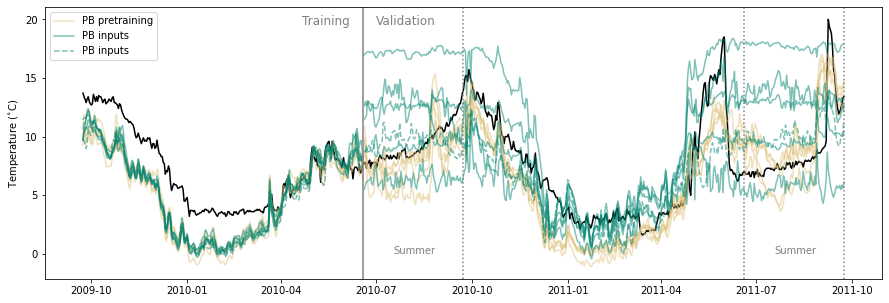

In [6]:
exp_dir_ls = ['pretrain_1', 'pretrain_2', 'pretrain_3', 'pretrain_4', 'pretrain_5',
              'no_pretrain_1', 'no_pretrain_2', 'no_pretrain_3', 'no_pretrain_4', 'no_pretrain_5',
              'no_pretrain_1_300']

start = datetime.datetime(2009, 9, 23, 0, 0, 0)
end = datetime.datetime(2011, 9, 23, 0, 0, 0)

plt.figure(figsize = (15, 5))

count = 0
for exp_dir in exp_dir_ls:
    
    pred_file_trn = "../river-dl/" + exp_dir + "/trn_preds.feather"
    pred_file_val = "../river-dl/" + exp_dir + "/val_preds.feather"
    obs_file = "../river-dl/data_DRB/Obs_temp_flow_drb_full_no3558"
    spatial_idx_name= "seg_id_nat"
    time_idx_name= "date"
    
    var_data_trn = fmt_preds_obs(pred_file_trn, obs_file, spatial_idx_name, time_idx_name)
    for data_var_trn, data_trn in var_data_trn.items():
        data_trn.reset_index(inplace=True)
        if count == 0:
            i = 1566 ###################################################################################### SPECIFY RIVER SEGMENT
        clipped_df_trn = data_trn[data_trn['date'] >= start]
        clipped_df_trn = clipped_df_trn[clipped_df_trn['date'] <= end]
        clipped_df_trn = clipped_df_trn[clipped_df_trn['seg_id_nat'] == i]

    var_data_val = fmt_preds_obs(pred_file_val, obs_file, spatial_idx_name, time_idx_name)
    for data_var_val, data_val in var_data_val.items():
        data_val.reset_index(inplace=True)
        clipped_df_val = data_val[data_val['date'] >= start]
        clipped_df_val = clipped_df_val[clipped_df_val['date'] <= end]
        clipped_df_val = clipped_df_val[clipped_df_val['seg_id_nat'] == i]
        
    if 'no' in exp_dir:
        col = PBinput_col
    else:
        col = pretrain_col
    if count == 0:
        plt.plot(clipped_df_trn['date'], clipped_df_trn['obs'], color = 'black')
        plt.plot(clipped_df_val['date'], clipped_df_val['obs'], color = 'black')
    if exp_dir == 'pretrain_1':
        plt.plot(clipped_df_trn['date'], clipped_df_trn['pred'], color = col, alpha = 0.5, label = 'PB pretraining')
        plt.plot(clipped_df_val['date'], clipped_df_val['pred'], color = col, alpha = 0.5)
    elif exp_dir == 'no_pretrain_1':
        plt.plot(clipped_df_trn['date'], clipped_df_trn['pred'], color = col, alpha = 0.5, label = 'PB inputs')
        plt.plot(clipped_df_val['date'], clipped_df_val['pred'], color = col, alpha = 0.5)
    elif exp_dir == 'no_pretrain_1_300':
        plt.plot(clipped_df_trn['date'], clipped_df_trn['pred'], color = col, alpha = 0.5, label = 'PB inputs', linestyle = '--')
        plt.plot(clipped_df_val['date'], clipped_df_val['pred'], color = col, alpha = 0.5, linestyle = '--')
    else:
        plt.plot(clipped_df_trn['date'], clipped_df_trn['pred'], color = col, alpha = 0.5)
        plt.plot(clipped_df_val['date'], clipped_df_val['pred'], color = col, alpha = 0.5)
    count += 1
    
plt.axvline(x = datetime.datetime(2010, 6, 19, 0, 0, 0), linestyle = '-', color = 'grey')
plt.text(datetime.datetime(2010, 7, 1, 0, 0, 0), 19.5, 'Validation', color = 'grey', fontsize = 12)
plt.text(datetime.datetime(2010, 4, 21, 0, 0, 0), 19.5, 'Training', color = 'grey', fontsize = 12)
plt.axvline(x = datetime.datetime(2010, 9, 23, 0, 0, 0), linestyle = ':', color = 'grey')
plt.text(datetime.datetime(2010, 7, 18, 0, 0, 0), 0, 'Summer', color = 'grey')

plt.axvline(x = datetime.datetime(2011, 6, 19, 0, 0, 0), linestyle = ':', color = 'grey')
plt.axvline(x = datetime.datetime(2011, 9, 23, 0, 0, 0), linestyle = ':', color = 'grey')
plt.text(datetime.datetime(2011, 7, 18, 0, 0, 0), 0, 'Summer', color = 'grey')

plt.ylabel('Temperature ($^{\circ}$C)')

plt.legend()

plt.savefig('PB_experiment_TimeSeries1566_300IDd.png', dpi = 300)

/opt/venv/reticulate/lib/python3.8/site-packages/river_dl/postproc_utils.py:58: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  obs = xr.open_zarr(obs_file).to_dataframe()
/opt/venv/reticulate/lib/python3.8/site-packages/river_dl/postproc_utils.py:58: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with za

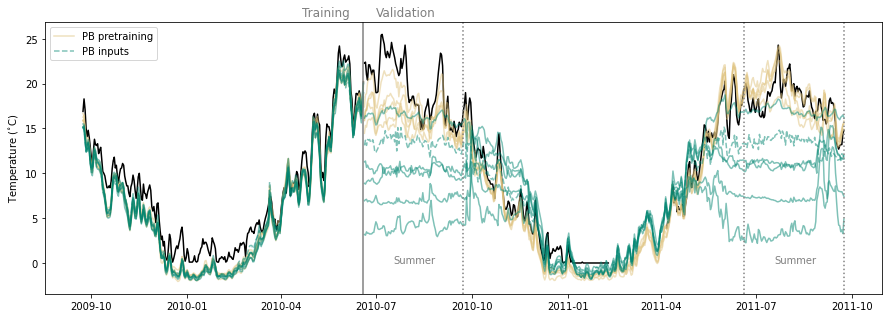

In [7]:
exp_dir_ls = ['pretrain_1', 'pretrain_2', 'pretrain_3', 'pretrain_4', 'pretrain_5',
              'no_pretrain_1', 'no_pretrain_2', 'no_pretrain_3', 'no_pretrain_4', 'no_pretrain_5',
              'no_pretrain_1_300']

start = datetime.datetime(2009, 9, 23, 0, 0, 0)
end = datetime.datetime(2011, 9, 23, 0, 0, 0)

plt.figure(figsize = (15, 5))

count = 0
for exp_dir in exp_dir_ls:
    
    pred_file_trn = "../river-dl/" + exp_dir + "/trn_preds.feather"
    pred_file_val = "../river-dl/" + exp_dir + "/val_preds.feather"
    obs_file = "../river-dl/data_DRB/Obs_temp_flow_drb_full_no3558"
    spatial_idx_name= "seg_id_nat"
    time_idx_name= "date"
    
    var_data_trn = fmt_preds_obs(pred_file_trn, obs_file, spatial_idx_name, time_idx_name)
    for data_var_trn, data_trn in var_data_trn.items():
        data_trn.reset_index(inplace=True)
        if count == 0:
            i = 1573 ###################################################################################### SPECIFY RIVER SEGMENT
        clipped_df_trn = data_trn[data_trn['date'] >= start]
        clipped_df_trn = clipped_df_trn[clipped_df_trn['date'] <= end]
        clipped_df_trn = clipped_df_trn[clipped_df_trn['seg_id_nat'] == i]

    var_data_val = fmt_preds_obs(pred_file_val, obs_file, spatial_idx_name, time_idx_name)
    for data_var_val, data_val in var_data_val.items():
        data_val.reset_index(inplace=True)
        clipped_df_val = data_val[data_val['date'] >= start]
        clipped_df_val = clipped_df_val[clipped_df_val['date'] <= end]
        clipped_df_val = clipped_df_val[clipped_df_val['seg_id_nat'] == i]
        
    if 'no' in exp_dir:
        col = PBinput_col
    else:
        col = pretrain_col
    if count == 0:
        plt.plot(clipped_df_trn['date'], clipped_df_trn['obs'], color = 'black')
        plt.plot(clipped_df_val['date'], clipped_df_val['obs'], color = 'black')
    if exp_dir == 'pretrain_1':
        plt.plot(clipped_df_trn['date'], clipped_df_trn['pred'], color = col, alpha = 0.5, label = 'PB pretraining')
        plt.plot(clipped_df_val['date'], clipped_df_val['pred'], color = col, alpha = 0.5)
    elif exp_dir == 'no_pretrain_1':
        plt.plot(clipped_df_trn['date'], clipped_df_trn['pred'], color = col, alpha = 0.5, label = 'PB inputs', linestyle = '--')
        plt.plot(clipped_df_val['date'], clipped_df_val['pred'], color = col, alpha = 0.5, linestyle = '--')
    else:
        plt.plot(clipped_df_trn['date'], clipped_df_trn['pred'], color = col, alpha = 0.5)
        plt.plot(clipped_df_val['date'], clipped_df_val['pred'], color = col, alpha = 0.5)
    count += 1
    
plt.axvline(x = datetime.datetime(2010, 6, 19, 0, 0, 0), linestyle = '-', color = 'grey')
plt.text(datetime.datetime(2010, 7, 1, 0, 0, 0), 27.5, 'Validation', color = 'grey', fontsize = 12)
plt.text(datetime.datetime(2010, 4, 21, 0, 0, 0), 27.5, 'Training', color = 'grey', fontsize = 12)
plt.axvline(x = datetime.datetime(2010, 9, 23, 0, 0, 0), linestyle = ':', color = 'grey')
plt.text(datetime.datetime(2010, 7, 18, 0, 0, 0), 0, 'Summer', color = 'grey')

plt.axvline(x = datetime.datetime(2011, 6, 19, 0, 0, 0), linestyle = ':', color = 'grey')
plt.axvline(x = datetime.datetime(2011, 9, 23, 0, 0, 0), linestyle = ':', color = 'grey')
plt.text(datetime.datetime(2011, 7, 18, 0, 0, 0), 0, 'Summer', color = 'grey')

plt.ylabel('Temperature ($^{\circ}$C)')

plt.legend()

plt.savefig('PB_experiment_TimeSeries1573_300IDd.png', dpi = 300)